## A. KEGIATAN 1 – KLASIFIKASI CITRA (Transfer Learning CNN)



In [2]:
# 1. Impor semua library
!pip install -q tensorflow==2.19.0

import os, zipfile, shutil, random, glob, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [4]:
import os, zipfile

# 2–3. Deteksi & ekstrak dataset citra

ZIP_PATH     = "/content/citra.zip"
EXTRACT_DIR  = "/content/citra_raw"

SOURCE_DIR = None

if os.path.isdir(ZIP_PATH):

    SOURCE_DIR = ZIP_PATH
    print("citra.zip terdeteksi sebagai FOLDER, lewati proses ekstrak ZIP.")
else:
    try:
        with zipfile.ZipFile(ZIP_PATH, "r") as zf:
            zf.extractall(EXTRACT_DIR)
        print("Berhasil ekstrak ke:", EXTRACT_DIR)


        subdirs = [d for d in os.listdir(EXTRACT_DIR)
                   if os.path.isdir(os.path.join(EXTRACT_DIR, d))]
        if len(subdirs) == 1:
            SOURCE_DIR = os.path.join(EXTRACT_DIR, subdirs[0])
        else:

            SOURCE_DIR = EXTRACT_DIR

        print("SOURCE_DIR diset ke:", SOURCE_DIR)

    except zipfile.BadZipFile:


        SOURCE_DIR = "/content/citra"


BASE_SPLIT_DIR = "/content/citra_split"
TRAIN_DIR      = os.path.join(BASE_SPLIT_DIR, "train")
VAL_DIR        = os.path.join(BASE_SPLIT_DIR, "val")
TEST_DIR       = os.path.join(BASE_SPLIT_DIR, "test")

for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(d, exist_ok=True)

classes = [d for d in os.listdir(SOURCE_DIR)
           if os.path.isdir(os.path.join(SOURCE_DIR, d))]
print("Kelas ditemukan:", classes)


Berhasil ekstrak ke: /content/citra_raw
SOURCE_DIR diset ke: /content/citra_raw/PetImages
Kelas ditemukan: ['Cat', 'Dog']


In [5]:
# 4. Bagi dataset ke dalam folder train, val, test (70%, 15%, 15%)

for cls in classes:
    src_cls_dir = os.path.join(SOURCE_DIR, cls)
    images = [f for f in os.listdir(src_cls_dir)
              if f.lower().endswith((".jpg", ".jpeg", ".png"))]

    train_files, temp_files = train_test_split(
        images, test_size=0.3, random_state=42
    )
    val_files, test_files = train_test_split(
        temp_files, test_size=0.5, random_state=42
    )

    for split_name, file_list in zip(
        ["train", "val", "test"],
        [train_files, val_files, test_files]
    ):
        dst_cls_dir = os.path.join(BASE_SPLIT_DIR, split_name, cls)
        os.makedirs(dst_cls_dir, exist_ok=True)
        for fname in file_list:
            shutil.copy2(
                os.path.join(src_cls_dir, fname),
                os.path.join(dst_cls_dir, fname)
            )

print("Selesai split dataset.")


Selesai split dataset.


Train: {'Cat': 8749, 'Dog': 8749}
Val  : {'Cat': 1875, 'Dog': 1875}
Test : {'Cat': 1875, 'Dog': 1875}


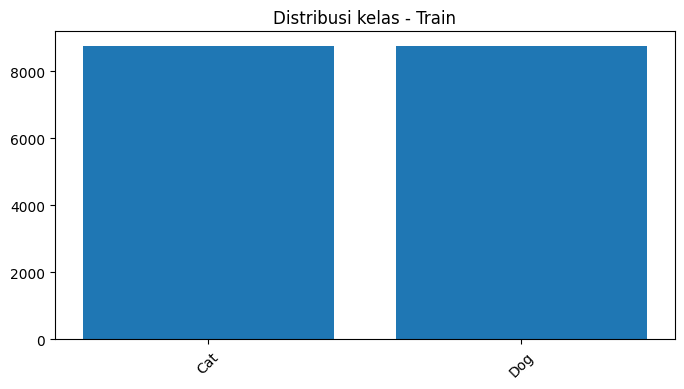

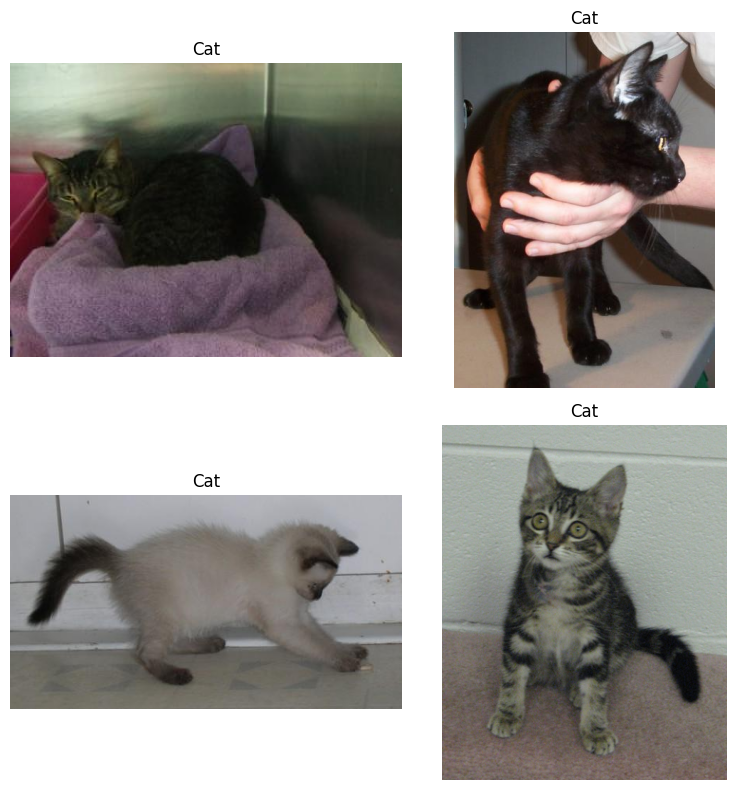

In [6]:
import matplotlib.pyplot as plt

# 5. EDA – distribusi kelas & contoh gambar

def count_images(base_dir):
    counts = {}
    for cls in classes:
        cls_dir = os.path.join(base_dir, cls)
        if os.path.exists(cls_dir):
            counts[cls] = len([
                f for f in os.listdir(cls_dir)
                if f.lower().endswith((".jpg", ".jpeg", ".png"))
            ])
        else:
            counts[cls] = 0
    return counts

train_counts = count_images(TRAIN_DIR)
val_counts   = count_images(VAL_DIR)
test_counts  = count_images(TEST_DIR)

print("Train:", train_counts)
print("Val  :", val_counts)
print("Test :", test_counts)

plt.figure(figsize=(8,4))
plt.bar(train_counts.keys(), train_counts.values())
plt.title("Distribusi kelas - Train")
plt.xticks(rotation=45)
plt.show()

# contoh beberapa gambar
sample_cls = classes[0]
sample_dir = os.path.join(TRAIN_DIR, sample_cls)
sample_files = os.listdir(sample_dir)[:4]

plt.figure(figsize=(8,8))
for i, fname in enumerate(sample_files):
    img = load_img(os.path.join(sample_dir, fname))
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(sample_cls)
plt.tight_layout()
plt.show()

In [7]:
# 6. Pre-processing & Data Augmentation

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

class_indices = train_gen.class_indices
idx_to_class  = {v: k for k, v in class_indices.items()}
print("Class indices:", class_indices)


Found 17498 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.
Class indices: {'Cat': 0, 'Dog': 1}


In [8]:
# Helper: simpan model (aman untuk Streamlit) ke folder /models
def save_model_simple(model, filename):
    os.makedirs("models", exist_ok=True)
    path = os.path.join("models", filename)
    model.save(path)
    print("✅ Model berhasil disimpan di:", path)

# (opsional) seed biar konsisten
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)


In [9]:
# 7A. Neural Network base (non-pretrained) — CNN dari nol
def build_base_cnn(input_shape=(224, 224, 3), num_classes=2):
    model = Sequential([
        Conv2D(32, (3,3), activation="relu", padding="same", input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(64, (3,3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(128, (3,3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D(),

        Flatten(),
        Dense(256, activation="relu"),
        Dropout(0.4),
        Dense(num_classes, activation="softmax"),
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model_base = build_base_cnn(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    num_classes=train_gen.num_classes
)

model_base.summary()

EPOCHS_BASE = 10
history_base = model_base.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_BASE
)

# Simpan model base
save_model_simple(model_base, "model_base_non_pretrained.keras")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,785,026 (98.36 MB)

 Trainable params: 25,784,578 (98.36 MB)

 Non-trainable params: 448 (1.75 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
426/547 ━━━━━━━━━━━━━━━━━━━━ 48s 404ms/step - accuracy: 0.5631 - loss: 5.8281

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


547/547 ━━━━━━━━━━━━━━━━━━━━ 239s 419ms/step - accuracy: 0.5669 - loss: 4.9630 - val_accuracy: 0.5928 - val_loss: 0.7164
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 221s 403ms/step - accuracy: 0.6120 - loss: 0.6489 - val_accuracy: 0.7021 - val_loss: 0.6072
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 222s 407ms/step - accuracy: 0.6510 - loss: 0.6228 - val_accuracy: 0.7197 - val_loss: 0.5276
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 219s 401ms/step - accuracy: 0.6681 - loss: 0.6017 - val_accuracy: 0.7445 - val_loss: 0.5242
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 219s 401ms/step - accuracy: 0.6766 - loss: 0.5906 - val_accuracy: 0.6835 - val_loss: 0.5726
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 220s 402ms/step - accuracy: 0.6898 - loss: 0.5728 - val_accuracy: 0.7211 - val_loss: 0.5189
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 220s 403ms/step - accuracy: 0.7012 - loss: 0.5593 - val_accuracy: 0.7771 - val_loss: 0.5007
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 220s 402ms/step - accuracy: 0.7154 - loss: 0.54

In [10]:
# 7B. Model Pretrained 1 — Transfer Learning (MobileNetV2)
base_model_p1 = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model_p1.trainable = False  # freeze backbone

x = base_model_p1.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(train_gen.num_classes, activation="softmax")(x)

model_p1 = Model(inputs=base_model_p1.input, outputs=outputs)

model_p1.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_p1.summary()

EPOCHS_P1 = 10
history_p1 = model_p1.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_P1
)

# Simpan model pretrained 1
save_model_simple(model_p1, "model_pretrained_1_mobilenetv2.keras")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 252s 431ms/step - accuracy: 0.9217 - loss: 0.1779 - val_accuracy: 0.9832 - val_loss: 0.0502
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 211s 386ms/step - accuracy: 0.9705 - loss: 0.0765 - val_accuracy: 0.9819 - val_loss: 0.0507
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 211s 386ms/step - accuracy: 0.9705 - loss: 0.0801 - val_accuracy: 0.9755 - val_loss: 0.0680
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 211s 386ms/step - accuracy: 0.9715 - loss: 0.0748 - val_accuracy: 0.9835 - val_loss: 0.0493
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 216s 395ms/step - accuracy: 0.9707 - loss: 0.0764 - val_accuracy: 0.9816 - val_loss: 0.0509
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 211s 386ms/step - accuracy: 0.9728 - loss: 0.0737 - val_accuracy: 0.9843 - val_loss: 0.0475
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 212s 386ms/step - accuracy: 0.9702 - loss: 0.0769 - val_accuracy: 0.9837 - val_loss: 0.0504
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 209s 382ms/step - accuracy: 0.9731 -

In [11]:
# 7C. Model Pretrained 2 — Transfer Learning (EfficientNetB0)
base_model_p2 = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model_p2.trainable = False  # freeze backbone

y = base_model_p2.output
y = GlobalAveragePooling2D()(y)
y = Dropout(0.35)(y)
outputs2 = Dense(train_gen.num_classes, activation="softmax")(y)

model_p2 = Model(inputs=base_model_p2.input, outputs=outputs2)

model_p2.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_p2.summary()

EPOCHS_P2 = 10
history_p2 = model_p2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_P2
)

# Simpan model pretrained 2
save_model_simple(model_p2, "model_pretrained_2_efficientnetb0.keras")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 266s 444ms/step - accuracy: 0.5055 - loss: 0.7049 - val_accuracy: 0.5109 - val_loss: 0.6926
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 214s 392ms/step - accuracy: 0.5051 - loss: 0.7057 - val_accuracy: 0.5000 - val_loss: 0.6947
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 211s 386ms/step - accuracy: 0.5069 - loss: 0.7019 - val_accuracy: 0.5000 - val_loss: 0.6925
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 213s 389ms/step - accuracy: 0.4983 - loss: 0.7051 - val_accuracy: 0.5000 - val_loss: 0.6979
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 212s 388ms/step - accuracy: 0.4949 - loss: 0.7039 - val_accuracy: 0.5000 - val_loss: 0.6921
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 214s 391ms/step - accuracy: 0.5033 - loss: 0.7028 - val_accuracy: 0.5152 - val_loss: 0.6919
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 214s 391ms/step - accuracy: 0.5009 - loss: 0.7024 - val_accuracy: 0.5027 - val_loss: 0.6923
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 213s 389ms/step - accuracy: 0.5123 -

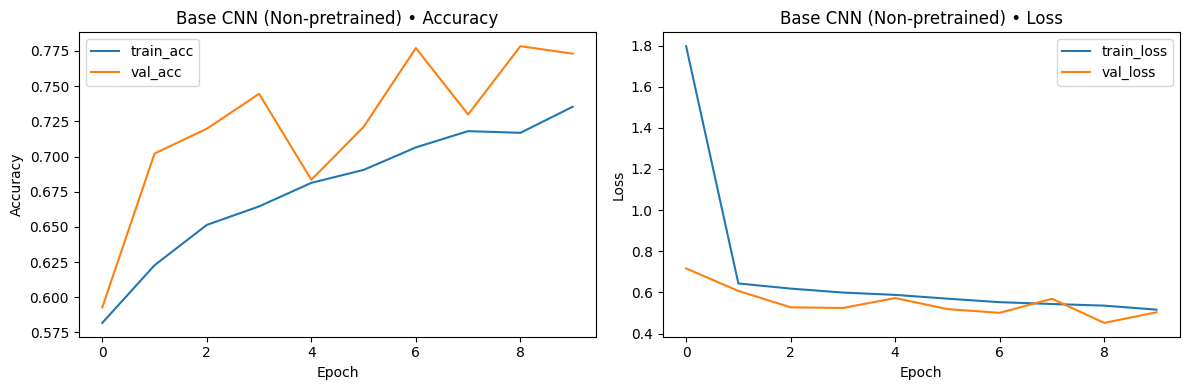

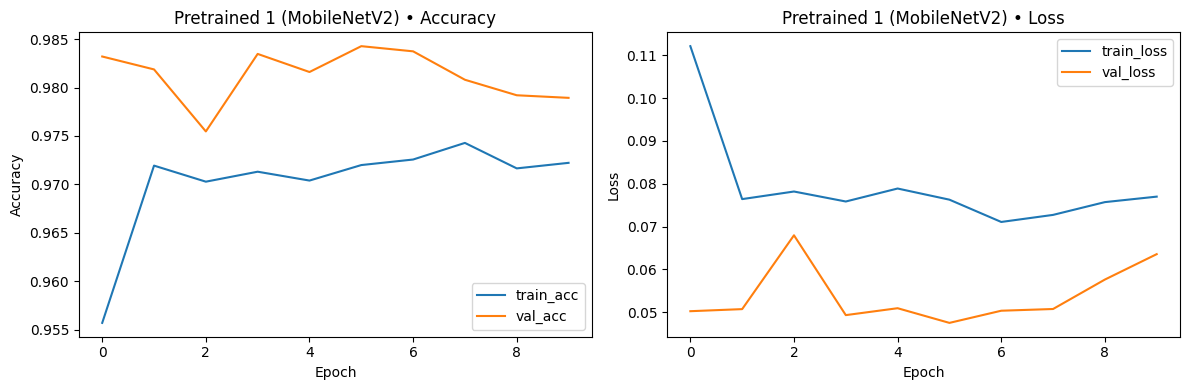

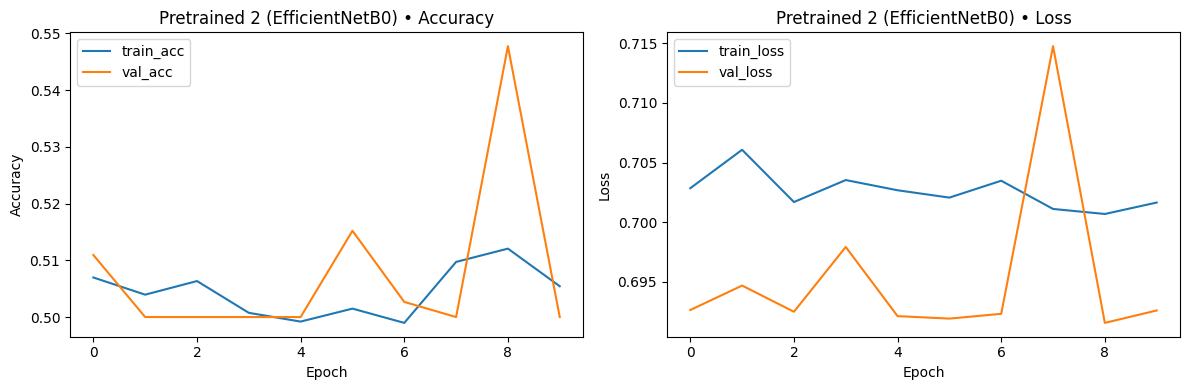


===== Base CNN (Non-pretrained) =====
              precision    recall  f1-score   support

         Cat       0.78      0.82      0.80      1875
         Dog       0.81      0.77      0.79      1875

    accuracy                           0.80      3750
   macro avg       0.80      0.80      0.80      3750
weighted avg       0.80      0.80      0.80      3750

Confusion Matrix:
 [[1535  340]
 [ 424 1451]]
Inference time (1 pass test set): 10.378 detik


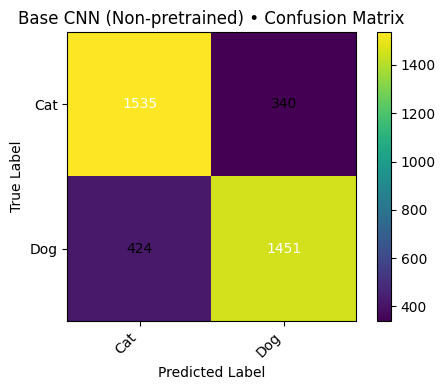


===== Pretrained 1 (MobileNetV2) =====
              precision    recall  f1-score   support

         Cat       0.99      0.96      0.98      1875
         Dog       0.97      0.99      0.98      1875

    accuracy                           0.98      3750
   macro avg       0.98      0.98      0.98      3750
weighted avg       0.98      0.98      0.98      3750

Confusion Matrix:
 [[1809   66]
 [  15 1860]]
Inference time (1 pass test set): 10.373 detik


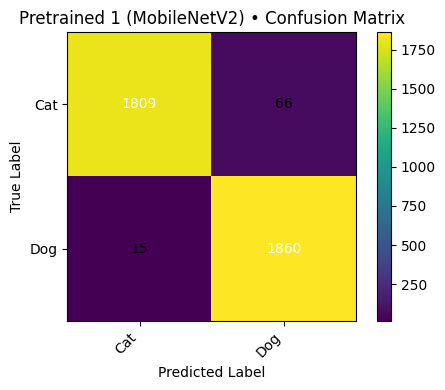


===== Pretrained 2 (EfficientNetB0) =====
              precision    recall  f1-score   support

         Cat       0.00      0.00      0.00      1875
         Dog       0.50      1.00      0.67      1875

    accuracy                           0.50      3750
   macro avg       0.25      0.50      0.33      3750
weighted avg       0.25      0.50      0.33      3750

Confusion Matrix:
 [[   0 1875]
 [   0 1875]]
Inference time (1 pass test set): 7.159 detik


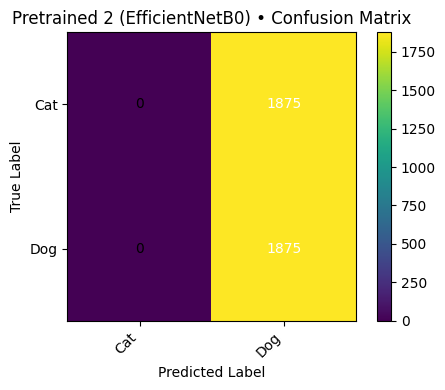

,Model,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1,Inference Time (s)
1,Pretrained 1 (MobileNetV2),0.978400,0.978754,0.978400,0.978396,0.978396,10.372936
0,Base CNN (Non-pretrained),0.796267,0.796862,0.796267,0.796164,0.796164,10.378268
2,Pretrained 2 (EfficientNetB0),0.500000,0.250000,0.500000,0.333333,0.333333,7.159172


In [15]:
# 9. Evaluasi & Analisis Performa (3 model)

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score
)

def plot_history(history, title_prefix="Model"):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history.history.get("accuracy", []), label="train_acc")
    plt.plot(history.history.get("val_accuracy", []), label="val_acc")
    plt.title(f"{title_prefix} • Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history.get("loss", []), label="train_loss")
    plt.plot(history.history.get("val_loss", []), label="val_loss")
    plt.title(f"{title_prefix} • Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    """
    Visualisasi confusion matrix pakai matplotlib (tanpa seaborn).
    cm: np.ndarray shape (n_classes, n_classes)
    """
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)

    # tulis angka di tiap cell
    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


def evaluate_model(model, test_gen, model_name="model", show_cm=True):
    test_gen.reset()

    t0 = time.time()
    y_prob = model.predict(test_gen, verbose=0)
    infer_time = time.time() - t0

    y_pred = np.argmax(y_prob, axis=1)
    y_true = test_gen.classes

    target_names = [idx_to_class[i] for i in range(len(idx_to_class))]

    report_dict = classification_report(
        y_true, y_pred, target_names=target_names, output_dict=True, zero_division=0
    )
    report_str = classification_report(
        y_true, y_pred, target_names=target_names, zero_division=0
    )

    cm = confusion_matrix(y_true, y_pred)

    print(f"\n===== {model_name} =====")
    print(report_str)
    print("Confusion Matrix:\n", cm)
    print(f"Inference time (1 pass test set): {infer_time:.3f} detik")

    # ✅ tampilkan visualisasi CM
    if show_cm:
        plot_confusion_matrix(cm, target_names, title=f"{model_name} • Confusion Matrix")

    # ringkas metrik untuk tabel perbandingan
    acc = accuracy_score(y_true, y_pred)
    macro_p = report_dict["macro avg"]["precision"]
    macro_r = report_dict["macro avg"]["recall"]
    macro_f1 = report_dict["macro avg"]["f1-score"]
    w_f1 = report_dict["weighted avg"]["f1-score"]

    return {
        "Model": model_name,
        "Accuracy": acc,
        "Macro Precision": macro_p,
        "Macro Recall": macro_r,
        "Macro F1": macro_f1,
        "Weighted F1": w_f1,
        "Inference Time (s)": infer_time
    }


# 9A. Plot history masing-masing model
plot_history(history_base, "Base CNN (Non-pretrained)")
plot_history(history_p1,   "Pretrained 1 (MobileNetV2)")
plot_history(history_p2,   "Pretrained 2 (EfficientNetB0)")

# 9B. Evaluasi di data test + Confusion Matrix
results = []
results.append(evaluate_model(model_base, test_gen, "Base CNN (Non-pretrained)", show_cm=True))
results.append(evaluate_model(model_p1,   test_gen, "Pretrained 1 (MobileNetV2)", show_cm=True))
results.append(evaluate_model(model_p2,   test_gen, "Pretrained 2 (EfficientNetB0)", show_cm=True))

compare_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
compare_df


In [16]:
# 10. Uji Prediksi Sampel (bandingkan 3 model)

def preprocess_single_image(img_path, target_size=(224,224)):
    img = load_img(img_path, target_size=target_size)
    arr = img_to_array(img) / 255.0
    return np.expand_dims(arr, axis=0), img

def predict_single(model, img_path):
    x, img = preprocess_single_image(img_path, IMG_SIZE)
    prob = model.predict(x, verbose=0)[0]
    pred_idx = int(np.argmax(prob))
    return pred_idx, float(np.max(prob)), img

# Ambil 10 gambar acak dari test
all_test_files = []
for cls in os.listdir(TEST_DIR):
    cls_dir = os.path.join(TEST_DIR, cls)
    if os.path.isdir(cls_dir):
        all_test_files += glob.glob(os.path.join(cls_dir, "*.*"))

sample_files = random.sample(all_test_files, k=min(10, len(all_test_files)))

models_to_compare = [
    ("Base CNN", model_base),
    ("Pretrained 1 (MobileNetV2)", model_p1),
    ("Pretrained 2 (EfficientNetB0)", model_p2),
]

for path_img in sample_files:
    true_label = os.path.basename(os.path.dirname(path_img))
    print("\nGambar:", os.path.basename(path_img), "| True:", true_label)

    for name, mdl in models_to_compare:
        pred_idx, conf, _ = predict_single(mdl, path_img)
        pred_label = idx_to_class[pred_idx]
        print(f" - {name}: {pred_label} (conf={conf:.3f})")



Gambar: 2195.jpg | True: Cat
 - Base CNN: Cat (conf=0.577)
 - Pretrained 1 (MobileNetV2): Cat (conf=1.000)
 - Pretrained 2 (EfficientNetB0): Dog (conf=0.525)

Gambar: 1578.jpg | True: Cat
 - Base CNN: Cat (conf=0.560)
 - Pretrained 1 (MobileNetV2): Cat (conf=1.000)
 - Pretrained 2 (EfficientNetB0): Dog (conf=0.518)

Gambar: 12360.jpg | True: Dog
 - Base CNN: Dog (conf=0.732)
 - Pretrained 1 (MobileNetV2): Cat (conf=0.815)
 - Pretrained 2 (EfficientNetB0): Dog (conf=0.539)

Gambar: 1095.jpg | True: Dog
 - Base CNN: Dog (conf=0.690)
 - Pretrained 1 (MobileNetV2): Dog (conf=1.000)
 - Pretrained 2 (EfficientNetB0): Dog (conf=0.523)

Gambar: 11127.jpg | True: Cat
 - Base CNN: Cat (conf=0.514)
 - Pretrained 1 (MobileNetV2): Cat (conf=1.000)
 - Pretrained 2 (EfficientNetB0): Dog (conf=0.528)

Gambar: 6149.jpg | True: Dog
 - Base CNN: Dog (conf=0.570)
 - Pretrained 1 (MobileNetV2): Dog (conf=1.000)
 - Pretrained 2 (EfficientNetB0): Dog (conf=0.522)

Gambar: 4440.jpg | True: Dog
 - Base CNN: D

In [14]:
# Mapping label
train_gen.class_indices, idx_to_class

({'Cat': 0, 'Dog': 1}, {0: 'Cat', 1: 'Dog'})